# FNN zur Vorhersage vom Maschinenschäden

KI-Campus-Kurs Ganzheitliche angewandte KI im Ingenieursbereich - Deep Learning für sequentielle Prozessdaten (DLfsP) der TU Dresden.

angepasst von https://github.com/KI-Campus/DLfsP

# DLfsP Dense Neural Network am Beispiel Rattern
Kurs Deep Learning für sequentielle Prozessdaten  

#### In diesem Notebook wird das TensorFlow mit Dense Layern anhand des Anwendungsbeispiels Rattern geübt.

Bei der Fertigung von Bauteilen treten manchmal störende Schwingungen auf, sog. Rattern. Dieses schädigt die Werkzeuge und führt zu einer niedrigeren Bauteilqualität.

Im Datensatz "Rattern" werden die Drehzahl der Spindel und die Tiefe des Schnitts einer CNC-Fräse gemessen. Es soll ein Entscheidungsbaum erstellt werden. Dises soll vorhersagen können, bei welcher Kombination aus Drehzahl und Schnitttiefe das Rattern auftritt.

![Daten erfassen -> Daten erkunden -> Daten vorbereiten -> Modelle bilden -> Modelle validieren -> Modell testen & anwenden](Prozess_Modellentwicklung_v2.png "model development")

### 0. Bibliotheken importieren

In [1]:
''' Import der wichtigsten Pakete. '''
import numpy as np
import pandas as pd
import random 
import os

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns

#Einstellungen für die Grafikausgabe
plt.style.use('seaborn-v0_8-whitegrid') # Willi Hahn Korrektur depreceated matplotlib styles
plt.rcParams.update({'font.size': 14})  # Schriftgröße aller Textzeichen im Graphen
sns.set_style("whitegrid")


In [2]:
''' Überprüfe, ob TensorFlow installiert ist und die GPU oder die CPU nutzt. '''
print('TF version: ' + tf.__version__)
if tf.test.is_built_with_gpu_support():
    if len(tf.config.list_physical_devices('GPU'))==0:
         print('Achtung, TensorFlow nutzt gerade die CPU und nicht die GPU!')
    else:
        print('Default GPU Device: {}'.format(tf.config.list_physical_devices('GPU')))
        # GPU-Memory-Management:
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        session = tf.compat.v1.Session(config=config)
else:
    print('TensorFlow CPU version active')

TF version: 2.19.0
TensorFlow CPU version active


TODO:
* Wähle eine Zahl zwischen 1 und 100 für die Generierung deiner spezifischen Zufallszahlen my_seed=

Damit Ergebnisse Reproduzierbar sind, müssen mehrere Seeds für Zufallszahlengeneratoren gesetzt werden. 

AUSGABE:
* Gewählte Zufallszahl

In [3]:
''' Setzen von Seeds, um Reproduzierbarkeit zu ermöglichen. '''
# Erstelle eigene Zufallszahlen
my_seed = 2

# Ausgabe gewählte Zufallszahlen
print("\nGewählte Zahl für Zufallszahlen: \t" + str(my_seed))

# Seeds für diverse Zufallszahlengeneratoren setzen 
os.environ['PYTHONHASHSEED']=str(my_seed)
tf.random.set_seed(my_seed)
random.seed(my_seed)
np.random.seed(my_seed)


Gewählte Zahl für Zufallszahlen: 	2


## 1. Daten erfassen 

In [4]:
""" Daten mit pandas einlesen. """
df_train = pd.read_csv("SägeRattern Trainingsdaten.csv")
df_test = pd.read_csv("SägeRattern Testdaten.csv")
print('Daten erfolgreich importiert')

Daten erfolgreich importiert


## 2. Daten erkunden

In [5]:
""" Erste Zeilen des Trainingsdatensatzes als Beispiel. 
    Ist eine Standardisierung notwendig? """
df_train.head(5)
#df_train.groupby('Rattern').mean()

,Drehzahl Spindel,Tiefe des Schnitts,Rattern
0,8052.714883,0.005008,0
1,14609.266695,0.013545,0
2,10958.025235,0.016669,0
3,14826.239580,0.005246,1
4,8269.823433,0.009468,0


In [6]:
""" Statistische Beschreibung des Trainingsdatensatzes. """
df_train.describe()

,Drehzahl Spindel,Tiefe des Schnitts,Rattern
count,1000.000000,1000.000000,1000.000000
mean,11914.715950,0.011585,0.312000
std,2318.877498,0.006086,0.463542
min,8002.157250,0.001039,0.000000
25%,9896.591517,0.006148,0.000000
50%,11867.341154,0.011705,0.000000
75%,13946.390335,0.016934,1.000000
max,15965.799516,0.021996,1.000000


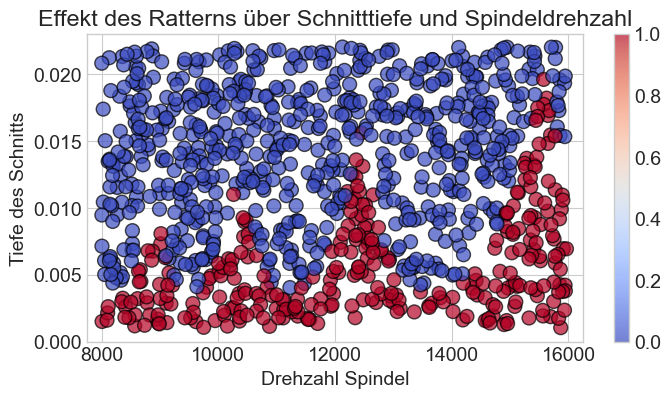

In [7]:
""" Ausgabe Klassenzugehörigkeit. """
fig = plt.figure(figsize=(8, 4))
surf = plt.scatter(df_train["Drehzahl Spindel"],
                   df_train["Tiefe des Schnitts"],
                   c=df_train["Rattern"],
                   cmap=plt.cm.coolwarm,
                   s=100,
                   alpha=0.7,
                   edgecolors="black")

plt.colorbar(surf)
plt.xlim(7750, 16250)
plt.ylim(0, 0.023)
plt.xlabel("Drehzahl Spindel")
plt.ylabel("Tiefe des Schnitts")
plt.title("Effekt des Ratterns über Schnitttiefe und Spindeldrehzahl")
plt.show()

## 3. Daten vorbereiten

In [8]:
""" Aufteilung in X und y. 
    to_numpy fpr TF. """
X_train = df_train.drop(columns=['Rattern']).to_numpy()
y_train = df_train['Rattern'].to_numpy(dtype='int32')

X_test = df_test.drop(columns=['Rattern']).to_numpy()
y_test = df_test['Rattern'].to_numpy(dtype='int32')


In [9]:
""" Aufteilen in Trainings- und Validierungsdaten. """
# Festlegen des Anteils an Validierungsdaten
validation_split = 0.15

# Aufteilung der Daten
X_train, X_val, y_train ,y_val = train_test_split(X_train, y_train, test_size=validation_split, shuffle=True, random_state=my_seed)

# Ausgabe, Anzahl der Samples je Datensatz
nr_train = len(X_train)
nr_val = len(X_val)
nr_test = len(X_test)
print(nr_train, "Trainingssequenzen")
print(nr_val, "Validierungssequenzen")
print(nr_test, "Testsequenzen")

850 Trainingssequenzen
150 Validierungssequenzen
200 Testsequenzen


In [10]:
""" Daten normalisieren. """
# Importieren und Anlernen des Scalers (d.h. Scaler lernt Mittelwerte und Standardabweichungen der Features)
# nur von den Trainingsdate, da ein data leakage durch train/test contamination vermieden werden muss.
scaler = StandardScaler().fit(X_train)

# Normierung der Daten mit den gelernten Paramatern und gleichzeitiges Formatieren
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print('Datenaufbereitung fertig')

Datenaufbereitung fertig


In [11]:
''' Überprüfen der Form der Numpy Arrays. '''
print('Shape X_train: ' + str(X_train.shape))
print('Shape X_val: ' + str(X_val.shape))
print('Shape X_test: ' + str(X_test.shape))

Shape X_train: (850, 2)
Shape X_val: (150, 2)
Shape X_test: (200, 2)


## 4. Modelle bilden
### <span style="color:#0000ff;">1.) Modellaufbau</span>

TODO:
* Zunächst muss die Modellstruktur definiert werden. 
* Die Anzahl der Layer und die Anzahl der Knoten/Nodes pro Layer ist einem selbst überlassen. 
* Probiere also verschiedene Modellgrößen aus, um das beste Modell für die Aufgabe zu finden.

Nützliche Links:
* https://keras.io/guides/sequential_model/   
* https://keras.io/api/layers/core_layers/dense/   

In [12]:
''' Modellaufbau 
    
    '''

# Import der notwendigen Klassen und Funktionen
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense 

# Bestimmung der Form eines einzelnen Trainingsbeispiels

# Definition des Modells
model = Sequential( name="FNN")
"""
*
* TODO: 
*      Dense Layers hinzufügen
*      hier umgebaut auf functional API (siehe letzte Zelle)
"""
input_shape = (2,) # Der Input in das Modell, ist ein 1D Tensor der Länge 2 
inputs = tf.keras.layers.Input(input_shape, name="input") # workaround, da kreas sonst input nicht im modell summary ausgibt.
outputs = tf.keras.layers.Dense(15,activation='relu', name="layer1")(inputs)
outputs = tf.keras.layers.Dense(14,activation='relu', name="layer2")(outputs)
outputs = tf.keras.layers.Dense(13,activation='relu', name="layer3")(outputs)
outputs = tf.keras.layers.Dense(1,activation='sigmoid', name="output")(outputs)
model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer1 (Dense)                       │ (None, 15)                  │              45 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 14)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dense)                       │ (None, 13)                  │             195 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              14 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 478 (1.87 KB)

 Trainable params: 478 (1.87 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# pip install pydot
keras.utils.plot_model(model, "model.png", dpi=200,
    show_layer_activations=True,
    show_dtype=True,
    show_layer_names=True,
    show_trainable=True,
    show_shapes=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


### <span style="color:#0000ff;">2.) Modellkompilierung</span>

Der Optimierer, die Loss Funktion und die Metrik wurden bereits festgelegt. 

In [14]:
''' Modell kompilieren. '''
# Optimizer festlegen
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3) # learning_rate=1e-3 ist default

# Einstellung für das spätere Training zum Kompilieren festlegen
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['acc'])


### <span style="color:#0000ff;">3.) Modelltraining</span>  

TODO:
* Wähle die Anzahl der Epochen aus, für die das Modell trainiert werden soll. 
* Danach müssen die Trainingsinputs, -outputs sowie die Validierungsdaten bestimmt werden.

Ausgabe: 
* Zwischenergebnisse je Epoche

In [15]:
''' Modell trainieren '''
"""
*
* TODO:
*       Füge die fehlenden Variablen ein!
*       (TODO löschen)
*
"""
# Festlegung der Batch_Size und Anzahl der Epoche
batch_size = 32 # also 27 Schritte je Epoche. loss und val_acc sind dann Mittelwerte.
epochs = 250
# Durchführen des Trainings. Die Ergebnisse je Epoche werden in der History gespeichert. 
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val, y_val), shuffle=True)

Epoch 1/250
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.3239 - loss: 0.7591 - val_acc: 0.3200 - val_loss: 0.7089
Epoch 2/250
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4535 - loss: 0.6997 - val_acc: 0.6800 - val_loss: 0.6701
Epoch 3/250
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7975 - loss: 0.6572 - val_acc: 0.8200 - val_loss: 0.6269
Epoch 4/250
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8500 - loss: 0.6064 - val_acc: 0.8200 - val_loss: 0.5678
Epoch 5/250
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8416 - loss: 0.5377 - val_acc: 0.8200 - val_loss: 0.4941
Epoch 6/250
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8344 - loss: 0.4558 - val_acc: 0.8200 - val_loss: 0.4249
Epoch 7/250
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8462 - loss: 0.3849 - val_acc: 0.8267 - val_loss: 0.3795
Epoch 8/250
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8488 - loss: 0.3421 - val_acc: 0.8400 - val_loss: 0.3588
Epoch 9/250
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.855

## 5. Modelle validieren

### Kennzahlen fürs Training und Validierung:

In [16]:
print('Kennzahlen (Loss und Accuracy Metrik) fürs Training:')
print(model.evaluate(X_train, y_train))
print('Kennzahlen (Loss und Accuracy Metrik) für Validierung:')
print(model.evaluate(X_val, y_val))

Kennzahlen (Loss und Accuracy Metrik) fürs Training:
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9458 - loss: 0.1469 
[0.1550625115633011, 0.9458823800086975]
Kennzahlen (Loss und Accuracy Metrik) für Validierung:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9313 - loss: 0.1813 
[0.17925769090652466, 0.9333333373069763]


### Visualisierung des Trainingsverlaufs

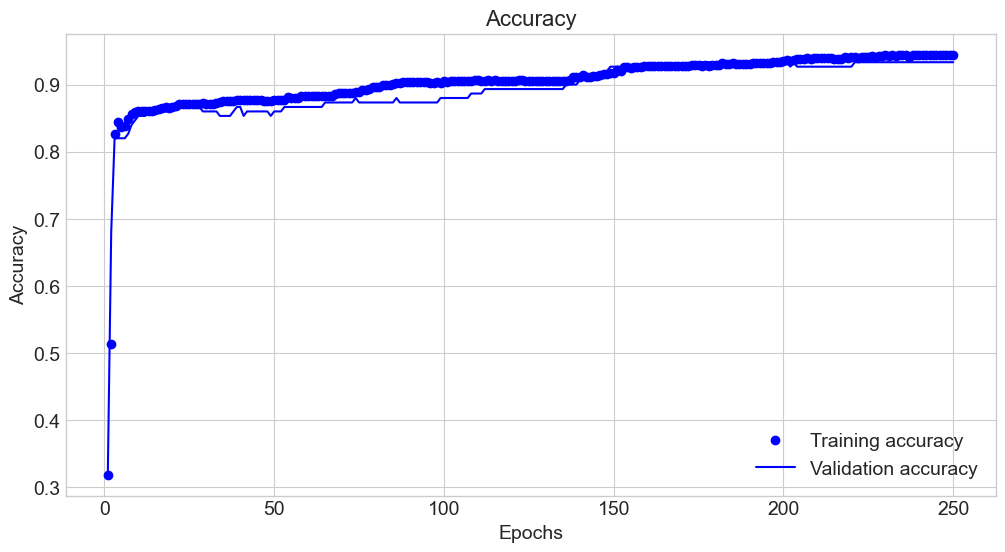

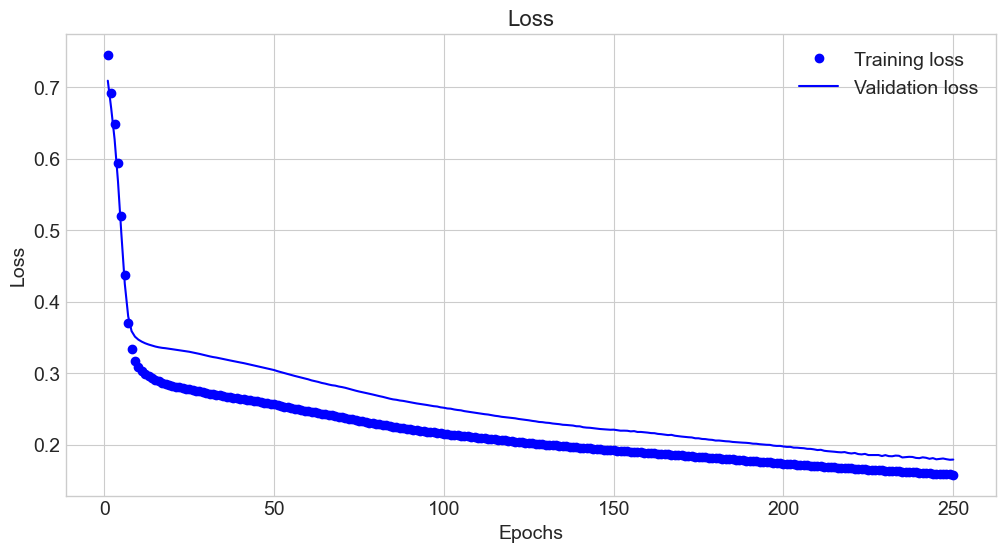

In [17]:
""" Trainingsverlauf plotten. 
    aus dem history Objekt """
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(train_acc) +1)

plt.figure(figsize=(12,6))
plt.plot(epochs, train_acc,'bo', label='Training accuracy')
plt.plot(epochs, val_acc,'b', label='Validation accuracy')

plt.title('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

plt.figure(figsize=(12,6))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Loss', fontsize = 16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

plt.show()

## 6. Modell testen & anwenden

Führen Sie diesen Schritt erst aus, wenn Sie mit Ihrem Modell zufrieden sind.  

Der Test eines Modells soll ermitteln, wie gut das Modell übertragbar und generalisierbar ist.  
Wenn Sie alle Modelle direkt testen, wählen Sie nur das Modell aus, was am Besten zum Testdatensatz passt. Aber nicht welches das Problem grundsätzlich am Besten löst. Sie Overfitten somit den Testdatensatz.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Ergebnis für den Test:
Accuracy: 	0.915
F1-Score: 	0.8777


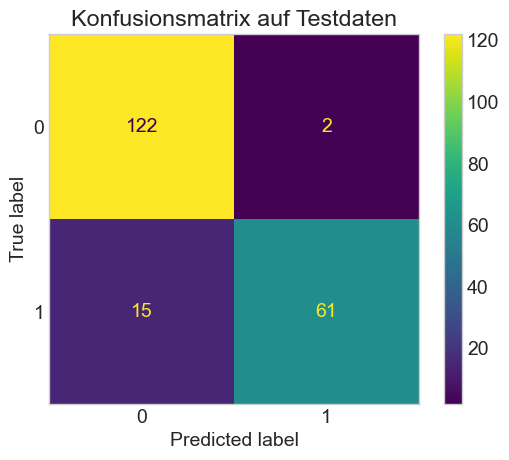

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       124
           1       0.97      0.80      0.88        76

    accuracy                           0.92       200
   macro avg       0.93      0.89      0.91       200
weighted avg       0.92      0.92      0.91       200



In [18]:
"""Modell anhand Testdaten bewerten"""
y_test_pred = (model.predict(X_test)>0.5).astype("int32")
# Berechne Genauigkeit auf den Testdaten
accuracy_test = accuracy_score(y_test, y_test_pred)

# Berechne den F1-Score auf den Testdaten
f1score_test = f1_score(y_test, y_test_pred)

# Ausgabe der Modellgenauigkeit
print('Ergebnis für den Test:')
print('Accuracy: \t' + str(round(accuracy_test, 4)))
print('F1-Score: \t' + str(round(f1score_test, 4)))

# Visualisierung der Konfusionsmatrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.grid()
plt.title('Konfusionsmatrix auf Testdaten')
plt.show()

# Classification Report
print('Classification Report')
print(classification_report(y_test, y_test_pred))

### Modellvorhersagen visualisieren

Da das Modell nur 2 Input-Parameter benötigt können wir alle möglichen Modellvorhersagen grafisch visualisieren.

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step


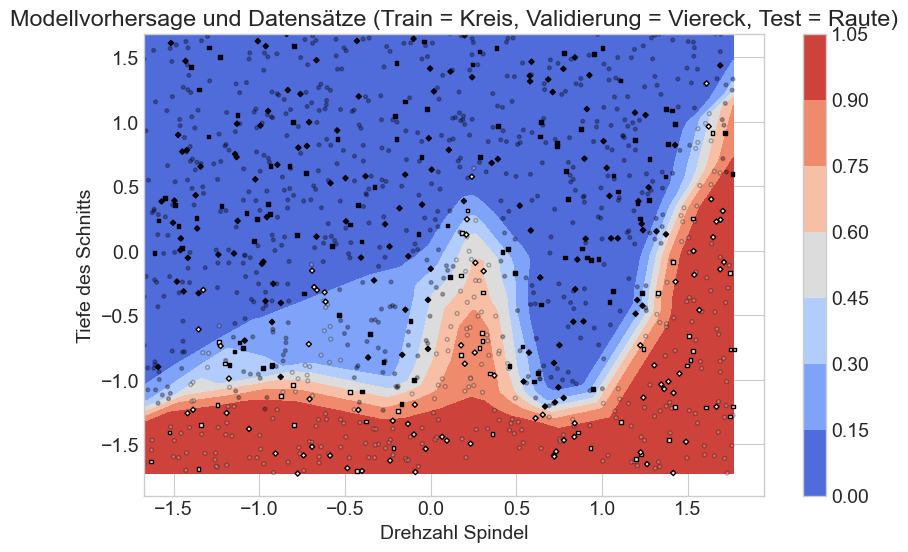

In [19]:
''' Visualisierung der Modellvorhersagen und Decision Boundary.'''
# Erstelle Grid für Modellausgabe
x = np.linspace(
    X_train[:, 0].min(), X_train[:, 0].max(), 200
)
y = np.linspace(
    X_train[:, 1].min(), X_train[:,1].max(), 200
)
X, Y = np.meshgrid(x, y)

# Berechne Modellvorhersage
z = pd.DataFrame({"Drehzahl Spindel": X.ravel(), "Tiefe des Schnitts": Y.ravel()})
z = model.predict(z)

# Ausgabe Modellvorhersage

Z = np.asarray(z).reshape(200, 200)
fig = plt.figure(figsize=(10, 6))
plt.title("Modellvorhersage und Datensätze (Train = Kreis, Validierung = Viereck, Test = Raute)")
plt.xlabel("Drehzahl Spindel")
plt.ylabel("Tiefe des Schnitts")
surf = plt.contourf(X, Y, Z, cmap=plt.cm.coolwarm)
plt.colorbar(surf)
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    marker="o",
    alpha=0.3,
    edgecolors="black",
    s=7)
plt.scatter(
    X_val[:, 0],
    X_val[:, 1],
    c=y_val,
    marker="s",
    edgecolors="black",
    s=7)
plt.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    marker="D",
    edgecolors="black",
    s=7)
plt.show()

# Warum ist die Spannweite zwiwchen -1,5 .. 1,5?
# Sind alle Peaks des Scatterplots der Originaldaten unterschieden?
# 